## Assignment: Анализ данных в задаче кредитного скоринга

LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)

SEX: пол клиента (1 = мужской, 2 = женский )

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

AGE: возраст в годах

PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)

BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь

PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре

default - индикатор невозврата денежных средств

#### Задание 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


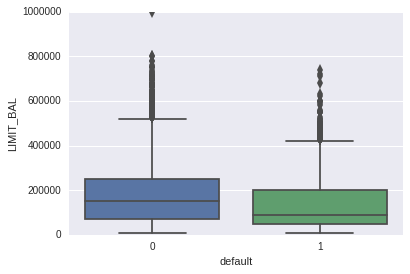

In [5]:
sns.boxplot(x='default', y='LIMIT_BAL', data=data,fliersize=8)

Наблюдение: в среднем кредитный лимит у тех, кто не вернул кредит, ниже, чем у тех, кто вернул

In [6]:
data_0 = data[data.default==0]
data_1 = data[data.default==1]

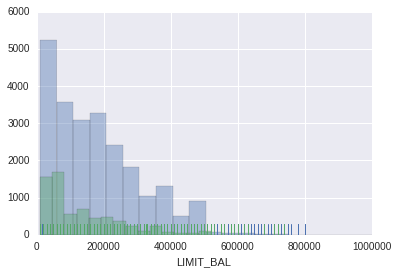

In [7]:
sns.distplot(data_0['LIMIT_BAL'], kde=False, rug=True, bins=20)
sns.distplot(data_1['LIMIT_BAL'], kde=False, rug=True, bins=20);

Проверим гипотезу о равенстве медианных оценок с помощью бутсрапирования выборки и построения интервальной оценки разности медиан

$H_0\colon med_0 = med_1$ 

$H_1\colon med_0 \neq med_1$ 

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

#### Интервальная оценка разности медиан

In [9]:
data_limit_0 = data_0['LIMIT_BAL'].values
data_limit_1 = data_1['LIMIT_BAL'].values

data_0_median_scores = map(np.median, get_bootstrap_samples(data_limit_0, 1000))
data_1_median_scores = map(np.median, get_bootstrap_samples(data_limit_1, 1000))

delta_median_scores = map(lambda x: x[1] - x[0], zip(data_1_median_scores, data_0_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 60000.  70000.]


Вывод: $95$% доверительный интервал не содержит $0$, значит гипотеза о равенстве медиан отвергается

### Задание 1b

Значимы ли полученные результаты с практической точки зрения ?

Проверим гипотезу о равенстве распределений. Для этого воспользуемся перестановочным критерием для независимых выборок: 

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [10]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [11]:
print "p-value: %f" % permutation_test(data_limit_0, data_limit_1, max_permutations = 10000)

p-value: 0.000100


Вывод: Можно отвергнуть гипотезу о равенстве распределений на уровне значимости $0.05$

### Задание 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

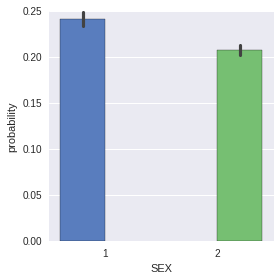

In [12]:
g = sns.factorplot(x="SEX", y="default", hue="SEX", data=data,
                   size=4, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("probability")

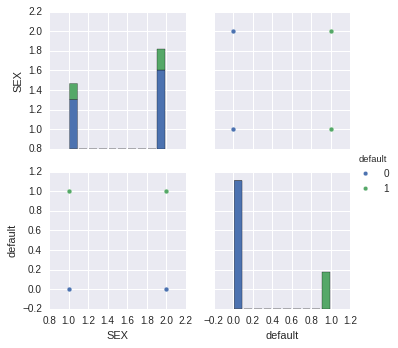

In [13]:
sns.set()
sns.pairplot(data[['SEX','default']], hue="default")

In [14]:
print data_1[data.SEX==1].shape[0]
print data_1[data.SEX==2].shape[0]
print data_0[data.SEX==1].shape[0]
print data_0[data.SEX==2].shape[0]

2873
3763
9015
14349


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Проверим гипотезу о равенстве доли женщин среди вернувших и не вернувших кредит:

$H_0 \colon p\_woman_0 = p\_woman_1$ 

$H_1 \colon p\_woman_0 \neq p\_woman_1$ 

Начнем проверку с построения доверительного интервала для доли:

In [15]:
import scipy

alpha = 0.05    
z = scipy.stats.norm.ppf(1 - alpha / 2.)

n0 = data_0.shape[0]
n1 = data_1.shape[0]

p1 = float(data_1[data.SEX==2].shape[0]) / n1
p0 = float(data_0[data.SEX==2].shape[0]) / n0
    
left_boundary = (p1 - p0) - z * np.sqrt(p1 * (1 - p1)/ n1 + p0 * (1 - p0)/ n0)
right_boundary = (p1 - p0) + z * np.sqrt(p1 * (1 - p1)/ n1 + p0 * (1 - p0)/ n0)
    
print "confidence interval: [%f, %f]" % (left_boundary, right_boundary)

confidence interval: [-0.060548, -0.033635]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Доверительный интервал не содержит $0$, значит гипотеза о равенстве отвергается.

Затем проверим гипотезу вторым способом, с помощью биномиального критерия для доли. (? статистического критерия)...

### Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

Посчитаем количество людей разного образования, вернувших и невернувших кредиты. Составим таблицу сопряженности из разности между наблюдаемым и ожидаемым количеством человек.

In [16]:
p = float(data_0.shape[0])/data.shape[0]
print 'Вероятность возврата кредита равна', p

Вероятность возврата кредита равна 0.7788


In [17]:
educ_exp_0 = data.EDUCATION.value_counts() * p
educ_exp_1 = data.EDUCATION.value_counts() * (1-p)
educ_exp_1[0] = 0

Ожидаемое количество:

In [19]:
data_edu_exp = pd.DataFrame([educ_exp_0, educ_exp_1], index=['def=0','def=1'])
data_edu_exp

,2,1,3,5,4,6,0
def=0,10926.564,8243.598,3829.3596,218.064,95.7924,39.7188,10.9032
def=1,3103.436,2341.402,1087.6404,61.936,27.2076,11.2812,0.0000


In [20]:
educ_obs_1 = data_1.EDUCATION.value_counts()
educ_obs_1[0] = 0
educ_obs_0 = data_0.EDUCATION.value_counts()

Реальное количество:

In [22]:
data_edu_obs = pd.DataFrame([educ_obs_0, educ_obs_1], index=['def=0','def=1'])
data_edu_obs

,0,1,2,3,4,5,6
def=0,14,8549,10700,3680,116,262,43
def=1,0,2036,3330,1237,7,18,8


In [66]:
d_educ_exp_1 = dict(educ_exp_1)
d_educ_exp_0 = dict(educ_exp_0)
d_educ_obs_1 = dict(educ_obs_1)
d_educ_obs_0 = dict(educ_obs_0)

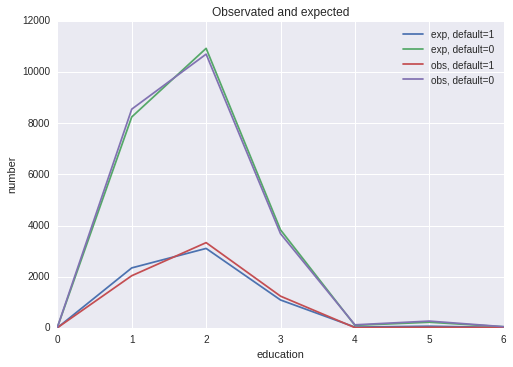

In [74]:
x1e, y1e = zip(*sorted(d_educ_exp_1.items()))
x0e, y0e = zip(*sorted(d_educ_exp_0.items()))
plot_1e = plt.plot(x1e, y1e, label='exp, default=1')
plot_0e = plt.plot(x0e, y0e, label='exp, default=0')

x1, y1 = zip(*sorted(d_educ_obs_1.items()))
x0, y0 = zip(*sorted(d_educ_obs_0.items()))
plot_1 = plt.plot(x1, y1, label='obs, default=1')
plot_0 = plt.plot(x0, y0, label='obs, default=0')
plt.legend()
plt.ylabel('number')
plt.xlabel('education')
plt.title('Observated and expected')
plt.show()

Итоговая таблица:

In [134]:
df_educ = pd.DataFrame([educ_obs_0 - educ_exp_0, educ_obs_1 - educ_exp_1], index=['def=0','def=1'])
df_educ.columns = ['0=доктор', '1=магистр', '2=бакалавр', '3=выпускник школы', '4=начальное образование', '5=прочее','6=не указано']
df_educ

,0=доктор,1=магистр,2=бакалавр,3=выпускник школы,4=начальное образование,5=прочее,6=не указано
def=0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
def=1,0.0000,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Приведем ячейки к одному масштабу. Разделим на соответвующие суммарное количество с данным уровнем образования.

In [90]:
df_educ_norm = pd.DataFrame([(educ_obs_0 - educ_exp_0)/data.EDUCATION.value_counts(), (educ_obs_1 - educ_exp_1)/data.EDUCATION.value_counts()], index=['def=0','def=1'])
df_educ_norm.columns = ['0=доктор', '1=магистр', '2=бакалавр', '3=выпускник школы', '4=начальное образование', '5=прочее','6=не указано']
df_educ_norm

,0=доктор,1=магистр,2=бакалавр,3=выпускник школы,4=начальное образование,5=прочее,6=не указано
def=0,0.2212,0.028852,-0.016149,-0.030376,0.164289,0.156914,0.064337
def=1,0.0000,-0.028852,0.016149,0.030376,-0.164289,-0.156914,-0.064337


Можно сделать вывод, что клиент с уровнем образование "бакалавр" или "выпускник школы" с большей вероятностью не вернет кредит. А клиенты с уровнем образования "доктор" склонны всегда возвращать долг.

Применим критерий Хи=квадрат для проверки равенства распределений. В качестве выборок передадим ожидаемое и наблюдаемое количество людей разного образования, вернувших кредит

In [87]:
a1 = d_educ_exp_0.values()
a2 = d_educ_obs_0.values()
scipy.stats.chisquare(a1, a2, ddof = 2)

Power_divergenceResult(statistic=33.59289731286394, pvalue=9.0308448032971584e-07)

Вывод: достигаемый уровень значимости меньше 0.05, значит гипотезу о равенстве распределений можно отвергнуть. Значит, образование влияет на то, вернет ли человек долг.

### Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Будем использовать коэффициент корреляции Мэтьюса

In [189]:
d2 = dict(data_0.MARRIAGE.value_counts())
d1 = dict(data_1.MARRIAGE.value_counts())
print d2
print d1

{0: 49, 1: 10453, 2: 12623, 3: 239}
{0: 5, 1: 3206, 2: 3341, 3: 84}


In [213]:
dict_marr = {'total': d2.values()+ d1.values(), 'status': ['NA','Married','Single',"ND",'NA','Married','Single','ND'], 'def': [0,0,0,0,1,1,1,1]}
dict_marr

{'def': [0, 0, 0, 0, 1, 1, 1, 1],
 'status': ['NA', 'Married', 'Single', 'ND', 'NA', 'Married', 'Single', 'ND'],
 'total': [49, 10453, 12623, 239, 5, 3206, 3341, 84]}

In [214]:
data_marr = pd.DataFrame(dict_marr)
data_marr

,def,status,total
0,0,NA,49
1,0,Married,10453
2,0,Single,12623
3,0,ND,239
4,1,NA,5
5,1,Married,3206
6,1,Single,3341
7,1,ND,84


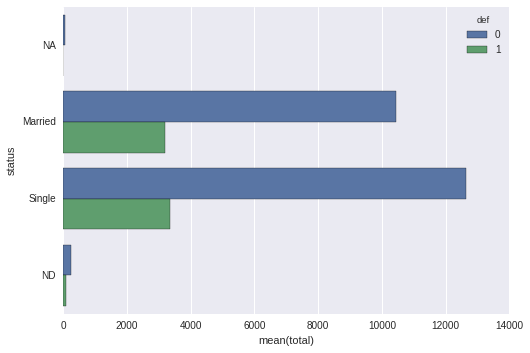

In [215]:
ax = sns.barplot(x='total', y='status', hue='def',data=data_marr)

Удалим данные с статусом 0 и 3, ввиду небольшого количество данных и не интерпритируемости

In [120]:
data_marr = data[(data.MARRIAGE==1) | (data.MARRIAGE==2)]

In [147]:
dict_marr = {0: [data_0[data_0.MARRIAGE==1].shape[0], data_0[data_0.MARRIAGE==2].shape[0]],
             1: [data_1[data_1.MARRIAGE==1].shape[0], data_1[data_1.MARRIAGE==2].shape[0]]}
data_marr = pd.DataFrame(dict_marr)
data_marr.columns = ['1=Married','2=Single']
data_marr

,1=Married,2=Single
0,10453,3206
1,12623,3341


In [150]:
def corr_mat(a,b,c,d):
    return (a*d - b*c)/np.sqrt((a+b)*(a+c)*(b+d)*(c+d))

print 'Коэффициент корреляции Мэтьюса равен', corr_mat(dict_marr[0][0],dict_marr[0][1],dict_marr[1][0],dict_marr[1][1])

Коэффициент корреляции Мэтьюса равен -0.0305553699204


Вывод: нет связи между семейным положением и возвратом кредитов

### Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

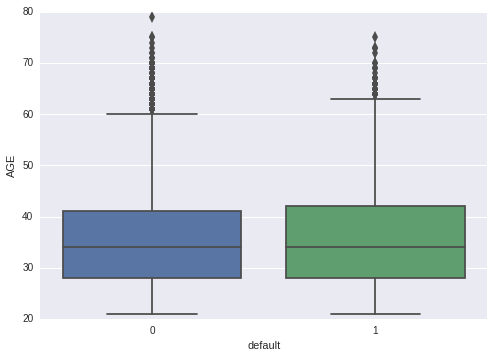

In [216]:
sns.boxplot(x='default', y='AGE', data=data,fliersize=8)

Наблюдение из графика: медианы возрастов примерно равны

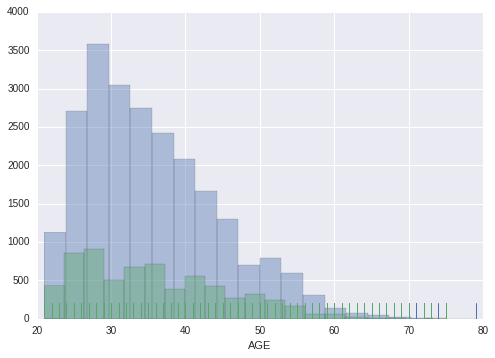

In [218]:
sns.distplot(data_0['AGE'], kde=False, rug=True, bins=20)
sns.distplot(data_1['AGE'], kde=False, rug=True, bins=20);

Проверим гипотезу о равенстве медианных оценок с помощью бутсрапирования выборки и построения интервальной оценки разности медиан

$H_0\colon med_0 = med_1$ 

$H_1\colon med_0 \neq med_1$ 

In [220]:
data_age_0 = data_0['AGE'].values
data_age_1 = data_1['AGE'].values

data_0_median_scores = map(np.median, get_bootstrap_samples(data_limit_0, 1000))
data_1_median_scores = map(np.median, get_bootstrap_samples(data_limit_1, 1000))

delta_median_scores = map(lambda x: x[1] - x[0], zip(data_1_median_scores, data_0_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [-1.  0.]


Вывод: несмотря на то, что $0$ является верхней границей доверительного интервала, гипотеза о равенстве медиан отвергается.

Значимы ли полученные результаты с практической точки зрения ?

Проверим гипотезу о равенстве распределений. Для этого воспользуемся перестановочным критерием для независимых выборок: 

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [222]:
print "p-value: %f" % permutation_test(data_limit_0, data_limit_1, max_permutations = 10000)

p-value: 0.017400


Вывод: гипотеза о равенстве распределений отвергается на уровне значимости 0.05, но принимается на уровне значимости 0.1